In [115]:
import numpy as np
import nengo
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import seaborn as sns
import pandas as pd
import scipy.io
import json
from scipy.stats import gaussian_kde
from pingouin import ancova
from scipy.stats import entropy, linregress, ks_2samp, chisquare
from model import SequentialPerception, build_network, detect_extrema_sequential
palette = sns.color_palette("colorblind")
sns.set_palette(palette)
sns.set(context='paper', style='ticks', rc={'font.size':12, 'mathtext.fontset': 'cm'})

## Helper Functions

In [2]:
def chi_squared_distance(a,b):
    distance = 0
    for i in range(len(a)):
        if a[i]+b[i]==0:
            continue
        else:
            distance += np.square(a[i] - b[i]) / (a[i]+b[i])
    return distance

In [3]:
def get_targeted_loss(simulated, empirical, dPs, max_cues, cue_step):
    loss = 0
    bins = np.arange(0.0, 2*max_cues+cue_step, cue_step)
    for dP in dPs:
        cues_sim = simulated.query("dP==@dP")['cues'].to_numpy()
        cues_emp = empirical.query("dP==@dP")['cues'].to_numpy()
        hist_cues_sim = np.histogram(cues_sim, bins=bins)[0]
        hist_cues_emp = np.histogram(cues_emp, bins=bins)[0]
        normed_hist_cues_sim = hist_cues_sim / len(cues_sim)
        normed_hist_cues_emp = hist_cues_emp / len(cues_emp)
        loss += chi_squared_distance(normed_hist_cues_sim, normed_hist_cues_emp)
    # print(f"loss {loss}")
    return loss

## Example sequence

In [ ]:
trial_num = 3
max_cues = 12
seed = 0
dP = 0.2
inputs = SequentialPerception(dt_sample=0.1, seed=seed, max_cues=max_cues)
inputs.create(dP=dP)
for cue in range(max_cues):
    print(f"trial {trial_num}, day {cue+1}: L: {inputs.sampled[0][:cue+1].astype(int)}, R {inputs.sampled[1][:cue+1].astype(int)}")
print(f"trial {trial_num}, L rose on {int(np.sum(inputs.sampled[0]))} days, and R rose on {int(np.sum(inputs.sampled[1]))} days, so {'L' if inputs.correct==0 else 'R'} is correct")

# Empirical data from Fiedler 2021

In [108]:
def plot_emp_RTs(max_cues, cue_step, aggregate=True, bw=1, cut=2):
    emp = pd.read_pickle("data/fiedler_trial.pkl").query("max_cues==@max_cues")
    if aggregate:
        fig = sns.FacetGrid(emp, col="dP", sharey='row', col_order=[0.4, 0.2, 0.1], palette=palette, height=2, aspect=1.5)
        fig.map_dataframe(sns.histplot, x="cues", kde=True, kde_kws={'bw_adjust': bw, 'cut': cut, 'clip': None},
                          bins=np.arange(0, 2*max_cues+1, 1), common_norm=False)
        fig.set_xlabels("Cues Sampled Per Trial")
        fig.set(xticks=[0,6,12,18,24])
        fig.add_legend()
        fig.savefig(f"plots/fiedler_RTs_{max_cues}.svg")
        fig.savefig(f"plots/fiedler_RTs_{max_cues}.png", dpi=600)
    else:
        # fig = sns.FacetGrid(emp.query("id in @ids"), row="id", col="dP", sharey='row', row_order=ids, col_order=[0.4, 0.2, 0.1], palette=palette, height=2, aspect=1.5)
        fig = sns.FacetGrid(emp, row="id", col="dP", sharey='row', col_order=[0.4, 0.2, 0.1], palette=palette, height=1.5, aspect=1.5)
        fig.map_dataframe(sns.histplot, x="cues", kde=True, kde_kws={'bw_adjust': bw, 'cut': cut, 'clip': None}, # [0, 2*max_cues]
                          bins=np.arange(0, 2*max_cues+1, 1), common_norm=False)
        fig.set_xlabels("Cues Sampled Per Trial")
        fig.set(xticks=[0,6,12,18,24])
        fig.add_legend()
        fig.savefig(f"plots/fiedler_RTs_{max_cues}_individual.svg")
        fig.savefig(f"plots/fiedler_RTs_{max_cues}_individual.png", dpi=600)

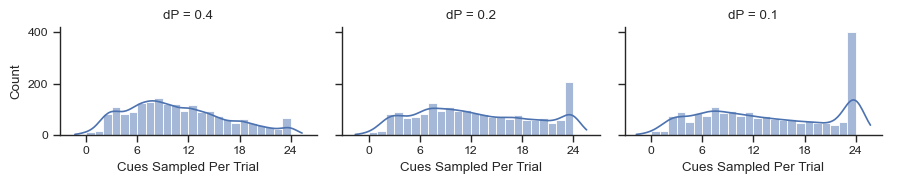

In [106]:
plot_emp_RTs(max_cues=12, cue_step=3, aggregate=True, bw=0.7, cut=1.5)

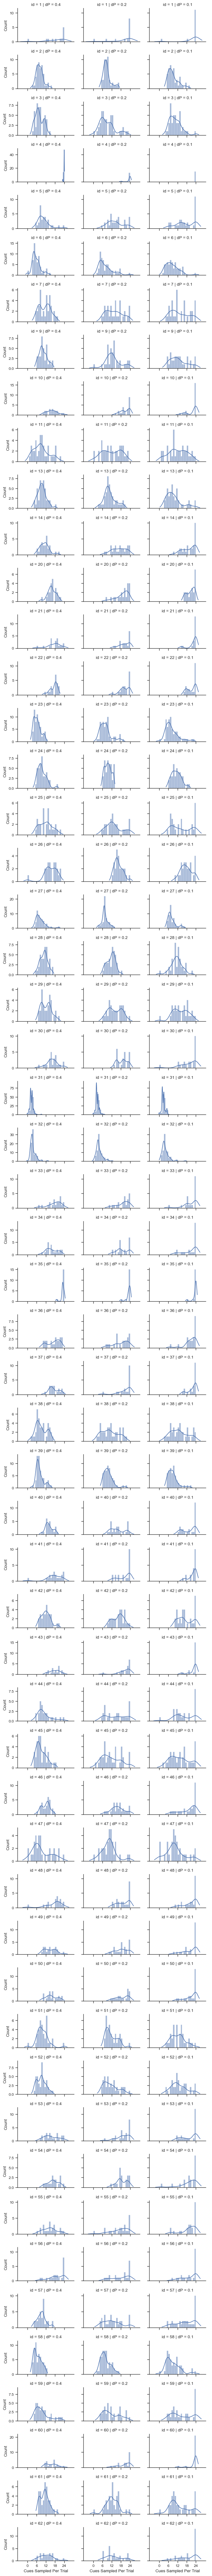

In [109]:
plot_emp_RTs(max_cues=12, cue_step=3, aggregate=False, bw=0.7, cut=1.5)

In [ ]:
def plot_recency_bias(max_cues, aggregate=True):
    emp = pd.read_pickle(f"data/fiedler_binned.pkl").query("max_cues==@max_cues")
    if aggregate:
        fig = sns.FacetGrid(emp, col="difficulty", col_order=["easy", "moderate", "hard"], palette=palette, height=2, aspect=1.5)
        fig.map_dataframe(sns.regplot, x="fraction_sampled", y='mean_cue_choice_aligned', x_estimator=np.mean, order=2, scatter_kws={'s':10})
        fig.set_xlabels("Cue Position")
        fig.set_ylabels("P(sample $\simeq$ choice)")
        fig.set(xticks=np.arange(0, 1.2, 0.2), yticks=np.arange(0.0, 0.8, 0.1))
    else:
        fig = sns.FacetGrid(emp, row="id", col="difficulty", col_order=["easy", "moderate", "hard"], palette=palette, height=2, aspect=1.5)
        fig.map_dataframe(sns.regplot, x="fraction_sampled", y='mean_cue_choice_aligned', x_estimator=np.mean)

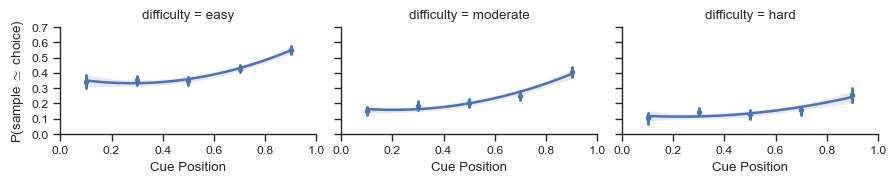

In [133]:
plot_recency_bias(max_cues=12)

# Neural Network Dynamics

In [6]:
def sequential_trial(dP, ramp=1, threshold=0.4, relative=1, perception_seed=0, network_seed=0, trial=0,
                 dt=0.001, max_cues=12, dt_sample=0.1, rA=1.0, nNeurons=500, legend=True, name="sequential"):

    inputs = SequentialPerception(dt_sample=dt_sample, seed=perception_seed+int(dP*10), max_cues=max_cues)
    for t in range(trial):
        inputs.create(dP=dP)  # lines up the input rng as though multiple trials had been previously simulated
    inputs.create(dP=dP)
    # print(inputs.Ps, inputs.sampled)
    net = build_network(inputs, seed=network_seed, ramp=ramp, threshold=threshold, relative=relative, rA=rA, nNeurons=nNeurons)
    sim = nengo.Simulator(net, progress_bar=False)
    choice = None
    RT = None
    while choice==None:
        sim.run(dt)
        if np.any(sim.data[net.pAction][-1,:] > 0.01):
            choice = np.argmax(sim.data[net.pAction][-1,:])
            RT = sim.trange()[-1]
        if sim.trange()[-1] > 2*max_cues*dt_sample-dt:
            choice = np.argmax(sim.data[net.pValue][-1,:])
            RT = sim.trange()[-1]
    correct = 1 if choice==net.inputs.correct else 0
    cues = min(int(RT/dt_sample)+1, 2*max_cues)

    fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=((7.08, 3)))
    for a in range(2):
        cue_label = "L" if a==0 else "R"
        axes[0].plot(sim.trange(), sim.data[net.pAccumulator][:,a], color=palette[a], lw=0.5, label=f"Evidence {cue_label}") 
    for a in range(2):
        cue_label = "L" if a==0 else "R"
        axes[0].plot(sim.trange(), np.cumsum(sim.data[net.pInputs][:,a]*dt*ramp), color=palette[a], label=f"True {cue_label}", linestyle="--") 
        axes[1].plot(sim.trange(), sim.data[net.pValue][:,a], color=palette[a], label=f"Value {cue_label}") 
    axes[1].plot(sim.trange(), net.threshold*np.ones_like(sim.trange()), label='Threshold', color="red", linestyle=":")
    axes[0].set(ylabel=r"$\mathbf{\hat{x}}(t)$", xlabel="Time (s)", title="Evidence in Accumulator")
    axes[1].set(xlabel="Time (s)", title="Decision Criteria")
    if legend:
        axes[0].legend(loc='upper left', ncol=2)
        leg = axes[1].legend(loc='upper left')
        leg.get_texts()[choice].set_color("lime" if correct else "red")
    print(f"RT {RT}, cues {cues}, choice {choice}, correct {net.inputs.correct}")
    plt.tight_layout()
    fig.savefig(f"plots/{name}.svg")
    fig.savefig(f"plots/{name}.png", dpi=600)

RT 0.779, cues 8, choice 0, correct 0


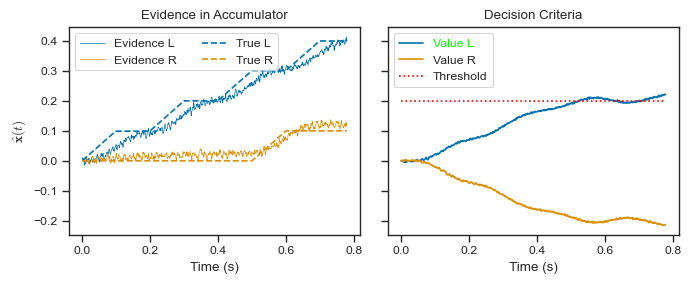

In [19]:
sequential_trial(dP=0.4, ramp=1, threshold=0.2, relative=1, dt_sample=0.1, perception_seed=1)

RT 1.459, cues 15, choice 0, correct 0


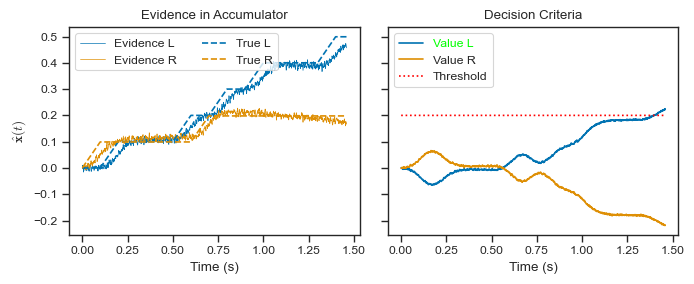

In [30]:
sequential_trial(dP=0.4, ramp=1, threshold=0.2, relative=1, dt_sample=0.1, perception_seed=8)

In [7]:
def double_trial(dP, ramps=[1,1], thresholds=[0.4,0.3], relatives=[1,1], perception_seed=0, network_seed=0, trial=0,
                 dt=0.001, max_cues=12, dt_sample=0.1, rA=1.5, nNeurons=500, legend=True, name="double"):

    fig, axes = plt.subplots(nrows=2, ncols=2, sharey=True, sharex=True, figsize=((7, 4)))
    for i in range(2):
        ramp, threshold, relative = ramps[i], thresholds[i], relatives[i]
        inputs = SequentialPerception(dt_sample=dt_sample, seed=perception_seed+int(dP*10), max_cues=max_cues)
        for t in range(trial):
            inputs.create(dP=dP)  # lines up the input rng as though multiple trials had been previously simulated
        inputs.create(dP=dP)
        # print(inputs.Ps, inputs.sampled)
        net = build_network(inputs, seed=network_seed, ramp=ramp, threshold=threshold, relative=relative, rA=rA, nNeurons=nNeurons)
        sim = nengo.Simulator(net, progress_bar=False)
        choice = None
        RT = None
        while choice==None:
            sim.run(dt)
            if np.any(sim.data[net.pAction][-1,:] > 0.01):
                choice = np.argmax(sim.data[net.pAction][-1,:])
                RT = sim.trange()[-1]
            if sim.trange()[-1] > 2*max_cues*dt_sample-dt:
                choice = np.argmax(sim.data[net.pValue][-1,:])
                RT = sim.trange()[-1]
        correct = 1 if choice==net.inputs.correct else 0
        cues = min(int(RT/dt_sample)+1, 2*max_cues)
        print(f"RT {RT}, cues {cues}, choice {choice}, correct {net.inputs.correct}")
    
        for a in range(2):
            axes[i][0].plot(sim.trange(), sim.data[net.pAccumulator][:,a], color=palette[a], lw=0.5, label=f"Model {i}") 
        for a in range(2):
            axes[i][1].plot(sim.trange(), sim.data[net.pValue][:,a], color=palette[a]) 
        axes[i][1].plot(sim.trange(), net.threshold*np.ones_like(sim.trange()), label=r'T {i}', color="red", linestyle=":")
        for a in range(2):
            axes[i][0].plot(sim.trange(), np.cumsum(sim.data[net.pInputs][:,a]*dt*ramp), color=palette[a], label=f"True {a}", linestyle="--") 
    axes[0][0].set(ylabel=r"$\mathbf{\hat{x}}(t)$", title="Cumulative Evidence, "+r"$R=$"+f"{ramps[0]}")
    axes[1][0].set(ylabel=r"$\mathbf{\hat{x}}(t)$", xlabel="Time (s)", title="Cumulative Evidence, "+r"$R=$"+f"{ramps[1]}")
    axes[0][1].set(title="Value, "+r"$T=$"+f"{thresholds[0]}")
    axes[1][1].set(xlabel="Time (s)", title="Value, "+r"$T=$"+f"{thresholds[1]}")
    axes[1][1].xaxis.set_minor_locator(MultipleLocator(dt_sample))
    # axes[0][0].legend(loc='upper left', ncol=3)
    # axes[0][1].legend(loc='upper left', ncol=2)
    plt.tight_layout()
    fig.savefig(f"plots/{name}.svg")
    fig.savefig(f"plots/{name}.png", dpi=600)

RT 0.35100000000000003, cues 4, choice 1, correct 0
RT 2.273, cues 23, choice 0, correct 0


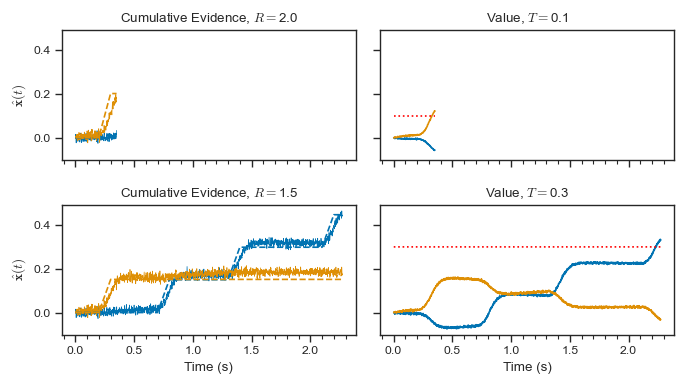

In [32]:
double_trial(dP=0.2, ramps=[2.0, 1.5], thresholds=[0.1, 0.3], relatives=[0.5, 0.5])

# Non-integration Models

In [8]:
def run_all_extrema(dPs=[0.4, 0.2, 0.1], experiment_time=60, dt_sample=0.1, cluster_size=3, positive_only=True, seed=0, perception_seed=0):
    columns1 = ['type', 'tid', 'difficulty', 'trial', 'position', 'cue', 'value', 'fraction_sampled', 'sampled_cues', 'max_cues', 
            'chosen', 'target', 'accuracy', 'cue_choice_aligned']
    columns2 = ['type', 'tid', 'dP', 'trial', 'accuracy', 'cues', 'max_cues']
    dfs1 = []
    dfs2 = []
    tid = 0
    for cluster_size in np.arange(1, 7, 1):
        for positive_only in [True, False]:
            for tiebreaker in ['random', 'largest']:
                tid += 1
                print(f"tid {tid}, cluster size {cluster_size}, consider only positive values {positive_only}, break ties {tiebreaker}")
                for max_cues in [12, 18]:
                    for dP in dPs:
                        if dP==0.4: difficulty = 'easy'
                        if dP==0.2: difficulty = 'moderate'
                        if dP==0.1: difficulty = 'hard'
                        inputs = SequentialPerception(seed=perception_seed+int(dP*10), max_cues=max_cues)
                        total_time = 0
                        trial = 0
                        while total_time < experiment_time:
                            inputs.create(dP=dP)
                            cues, accuracy, chosen = detect_extrema_sequential(
                                inputs, cluster_size=cluster_size, positive_only=positive_only, tiebreaker=tiebreaker, seed=seed)
                            # add position data
                            target = "L" if inputs.correct==0 else "R"
                            first = "L" if inputs.first==0 else "R"
                            Ls = inputs.sampled[0]
                            Rs = inputs.sampled[1]
                            for p in range(cues):
                                if first=="L":
                                    cue = 'L' if (p % 2 == 0) else 'R'
                                elif first=="R":
                                    cue = 'R' if (p % 2 == 0) else 'L'                                    
                                if cue == 'R':
                                    value = Rs[int(p/2)]
                                elif cue == 'L':
                                    value = Ls[int(p/2)]
                                fraction_sampled = (p+1) / cues
                                cue_choice_aligned = 0.0
                                if chosen=='R':
                                    if (cue=='R' and value==1) or (cue=='L' and value==0):
                                        cue_choice_aligned += 1
                                    else:
                                        cue_choice_aligned += -1
                                elif chosen=='L':
                                    if (cue=='L' and value==1) or (cue=='R' and value==0):
                                        cue_choice_aligned += 1
                                    else:
                                        cue_choice_aligned += -1
                                df1 = pd.DataFrame([[
                                    'extrema', tid, difficulty, trial, p, cue, value, fraction_sampled, cues, max_cues,
                                    chosen, target, accuracy, cue_choice_aligned
                                    ]], columns=columns1)
                                dfs1.append(df1)
                            # add trial data
                            dfs2.append(pd.DataFrame([['extrema', tid, dP, trial, 100*accuracy, cues, max_cues]], columns=columns2))
                            RT = cues * dt_sample
                            total_time += RT
                            trial += 1

    sim1 = pd.concat(dfs1, ignore_index=True)
    sim2 = pd.concat(dfs2, ignore_index=True)
    sim1.to_pickle(f"data/extrema_position.pkl")
    sim2.to_pickle(f"data/extrema_trial.pkl")

In [3]:
run_all_extrema(experiment_time=45)

tid 1, cluster size 1, consider only positive values True, break ties random
tid 2, cluster size 1, consider only positive values True, break ties largest
tid 3, cluster size 1, consider only positive values False, break ties random
tid 4, cluster size 1, consider only positive values False, break ties largest
tid 5, cluster size 2, consider only positive values True, break ties random
tid 6, cluster size 2, consider only positive values True, break ties largest
tid 7, cluster size 2, consider only positive values False, break ties random
tid 8, cluster size 2, consider only positive values False, break ties largest
tid 9, cluster size 3, consider only positive values True, break ties random
tid 10, cluster size 3, consider only positive values True, break ties largest
tid 11, cluster size 3, consider only positive values False, break ties random
tid 12, cluster size 3, consider only positive values False, break ties largest
tid 13, cluster size 4, consider only positive values True, b

In [9]:
def fit_extrema_to_fiedler(targeted_dPs=[0.2], max_cues=12, cue_step=5):
    pd.options.mode.chained_assignment = None
    extr_position = pd.read_pickle(f"data/extrema_position.pkl")
    extr_trial = pd.read_pickle(f"data/extrema_trial.pkl")
    emp_position = pd.read_pickle(f"data/fiedler_position.pkl")
    emp_trial = pd.read_pickle(f"data/fiedler_trial.pkl")
    dfs1 = []
    dfs2 = []
    for pid in emp_trial['pid'].unique():
        empirical = emp_trial.query('pid==@pid & max_cues==@max_cues & dP in @targeted_dPs')
        losses = []
        for sid in extr_trial['tid'].unique():
            simulated = extr_trial.query('tid==@sid & max_cues==@max_cues & dP in @targeted_dPs')
            loss = get_targeted_loss(simulated, empirical, targeted_dPs, max_cues, cue_step)
            losses.append(loss)
        best_tid = extr_trial['tid'].unique()[np.argmin(losses)]
        new_extr_position = extr_position.query("tid==@best_tid")
        new_extr_trial = extr_trial.query("tid==@best_tid")
        emp_id = empirical['id'].unique()[0]
        id_array_size_position = new_extr_position['tid'].to_numpy().shape[0]
        id_array_size_trial = new_extr_trial['tid'].to_numpy().shape[0]
        new_extr_position['id'] = emp_id * np.ones(id_array_size_position)
        new_extr_trial['id'] = emp_id * np.ones(id_array_size_trial)
        dfs1.append(new_extr_position)
        dfs2.append(new_extr_trial)
    extr_position_fit = pd.concat(dfs1, ignore_index=True)
    extr_trial_fit = pd.concat(dfs2, ignore_index=True)
    extr_position_fit.to_pickle(f"data/extrema_position_fit.pkl")
    extr_trial_fit.to_pickle(f"data/extrema_trial_fit.pkl")

In [105]:
fit_extrema_to_fiedler(max_cues=12, cue_step=5)

In [106]:
# pd.read_pickle(f"data/extrema_trial_fit.pkl")['id'].unique()

In [10]:
def bin_and_average_by_fraction_sampled():
    extrema_position_fit = pd.read_pickle("data/extrema_position_fit.pkl")
    bins = np.arange(0.0, 1.2, 0.2)
    columns = ['type', 'tid', 'id', 'difficulty', 'max_cues', 'fraction_sampled', 'mean_cue_choice_aligned', 'std_cue_choice_aligned']
    dfs = []
    for pid in extrema_position_fit['id'].unique():
        tid = extrema_position_fit.query('id==@pid')['tid'].unique()[0]
        for difficulty in extrema_position_fit['difficulty'].unique():
            for max_cues in extrema_position_fit['max_cues'].unique():
                data = extrema_position_fit.query('id==@pid & difficulty==@difficulty & max_cues==@max_cues')
                for i in range(len(bins)-1):
                    left = bins[i]
                    right = bins[i+1]
                    midpoint = (left + right) / 2
                    cue_choices_aligned = data.query('fraction_sampled>@left & fraction_sampled<=@right')['cue_choice_aligned'].to_numpy()
                    if len(cue_choices_aligned)>1:
                        mean = np.mean(cue_choices_aligned)
                        std = np.std(cue_choices_aligned)
                    else:
                        mean = None
                        std = None
                    df = pd.DataFrame([[
                        'extrema', tid, pid, difficulty, max_cues, midpoint, mean, std,
                        ]], columns=columns)
                    dfs.append(df)
    extrema_binned_fit = pd.concat(dfs, ignore_index=True)
    extrema_binned_fit.to_pickle("data/extrema_binned_fit.pkl")  # each row contains average and std data from one participant in one condition

In [108]:
bin_and_average_by_fraction_sampled()

C:\Users\Peter Duggins\AppData\Local\Temp\ipykernel_14184\3079684321.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  extrema_binned_fit = pd.concat(dfs, ignore_index=True)


In [109]:
# pd.read_pickle(f"data/extrema_binned_fit.pkl")

# Plot recency bias

In [11]:
def plot_recency_bias(simfile, empfile, extrfile, max_cues, facetgrid=False):
    emp = pd.read_pickle(f"data/{empfile}.pkl").query("max_cues==@max_cues")
    sim = pd.read_pickle(f"data/{simfile}.pkl").query("max_cues==@max_cues")
    extr = pd.read_pickle(f"data/{extrfile}.pkl").query("max_cues==@max_cues")
    combined = pd.concat([emp, sim, extr], ignore_index=True)
    if facetgrid:
        fig = sns.FacetGrid(combined, col="difficulty", col_order=["easy", "moderate", "hard"], hue='type', palette=palette, height=3, aspect=1)
        fig.map_dataframe(sns.regplot, x="fraction_sampled", y='mean_cue_choice_aligned', x_estimator=np.mean, order=2, x_jitter=1.0, scatter_kws={'s':10})
        fig.set_xlabels("Cue Position")
        fig.set_ylabels("P(sample $\simeq$ choice)")
        fig.add_legend()
        fig.set(xticks=np.arange(0, 1.2, 0.2), yticks=np.arange(0.0, 0.8, 0.1))
    else:
        fig = sns.lmplot(data=combined, x="fraction_sampled", y='mean_cue_choice_aligned', x_estimator=np.mean, order=2,
                         row=None, col="difficulty", hue='type', palette=palette, height=2.5, aspect=1, x_jitter=0.5, scatter_kws={'s':10})
        fig.set_xlabels("Cue Position")
        fig.set_ylabels("P(sample $\simeq$ choice)")
        fig.add_legend()
        fig.set(xticks=np.arange(0, 1.2, 0.2), yticks=np.arange(0.0, 0.8, 0.1))

    fig.savefig(f"plots/recency_bias.svg")
    fig.savefig(f"plots/recency_bias.png")

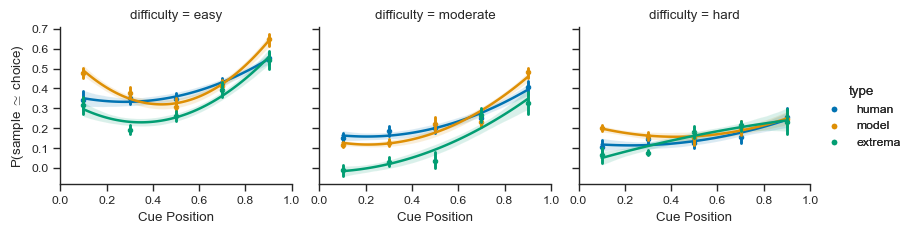

In [111]:
plot_recency_bias("fiedler_binned_may8b", "fiedler_binned", "extrema_binned_fit", max_cues=12)

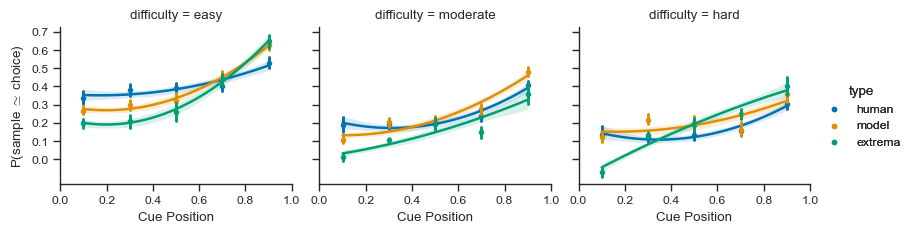

In [112]:
plot_recency_bias("fiedler_binned_may8b", "fiedler_binned", "extrema_binned_fit", max_cues=18)

# Plot distribution of RTs across all trials and all participants

In [17]:
def plot_RTs(simfile, empfile, extrfile, max_cues, cue_step=5, aggregate=True):
    emp = pd.read_pickle(f"data/{empfile}.pkl").query("max_cues==@max_cues")
    sim = pd.read_pickle(f"data/{simfile}.pkl").query("max_cues==@max_cues")
    extr = pd.read_pickle(f"data/{extrfile}.pkl").query("max_cues==@max_cues")
    # combined = pd.concat([emp, sim], ignore_index=True)
    combined = pd.concat([emp, sim, extr], ignore_index=True)
    combined = combined.astype({"id": int})
    bins = np.arange(0, 2*max_cues+cue_step, cue_step)
    if aggregate:
        fig = sns.FacetGrid(combined, hue='type', col="dP", col_order=[0.4, 0.2, 0.1], palette=palette, height=2, aspect=1.5)
        fig.map_dataframe(sns.histplot, x="cues", stat='percent', element="poly", bins=bins, common_norm=False, alpha=0.3)
        fig.set_xlabels("Cues Sampled Per Trial")
        fig.add_legend()
        fig.savefig(f"plots/fiedler_RTs_{max_cues}.svg")
        fig.savefig(f"plots/fiedler_RTs_{max_cues}.png", dpi=600)
    else:
        fig = sns.FacetGrid(combined, row="id", col="dP", hue='type', col_order=[0.4, 0.2, 0.1], palette=palette, height=2, aspect=1.5)
        fig.map_dataframe(sns.histplot, x="cues", stat='percent', element="poly", bins=bins, common_norm=False, alpha=0.3)
        fig.set_xlabels("Cues Sampled Per Trial")
        fig.add_legend()
        fig.savefig(f"plots/fiedler_RTs_{max_cues}_individual.svg")
        fig.savefig(f"plots/fiedler_RTs_{max_cues}_individual.png")

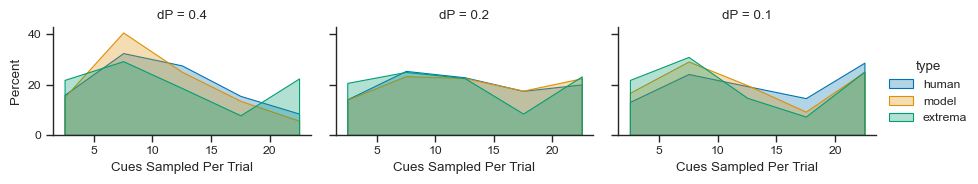

In [16]:
plot_RTs("fiedler_trial_may8b", "fiedler_trial", "extrema_trial_fit", max_cues=12, cue_step=5, aggregate=True)

In [ ]:
plot_RTs("fiedler_trial_may8b", "fiedler_trial", "extrema_trial_fit", max_cues=12, cue_step=5, aggregate=False)

### Replot specific participants

In [26]:
def plot_id_RTs(pids, simfile, empfile, extrfile, max_cues, cue_step=5):
    emp = pd.read_pickle(f"data/{empfile}.pkl").query("max_cues==@max_cues")
    sim = pd.read_pickle(f"data/{simfile}.pkl").query("max_cues==@max_cues")
    extr = pd.read_pickle(f"data/{extrfile}.pkl").query("max_cues==@max_cues")
    # combined = pd.concat([emp, sim], ignore_index=True)
    combined = pd.concat([emp, sim, extr], ignore_index=True)
    combined = combined.astype({"id": int})
    bins = np.arange(0, 2*max_cues+cue_step, cue_step)
    fig = sns.FacetGrid(combined.query("id in @pids"), row="id", col="dP", hue='type',
                        row_order=pids, col_order=[0.4, 0.2, 0.1], palette=palette, height=2, aspect=1.5)
    fig.map_dataframe(sns.histplot, x="cues", stat='percent', element="poly", bins=bins, common_norm=False, alpha=0.3)
    fig.set_xlabels("Cues Sampled Per Trial")
    fig.add_legend()
    fig.savefig(f"plots/fiedler_exemplars_RTs.svg")
    fig.savefig(f"plots/fiedler_exemplars_RTs.png")

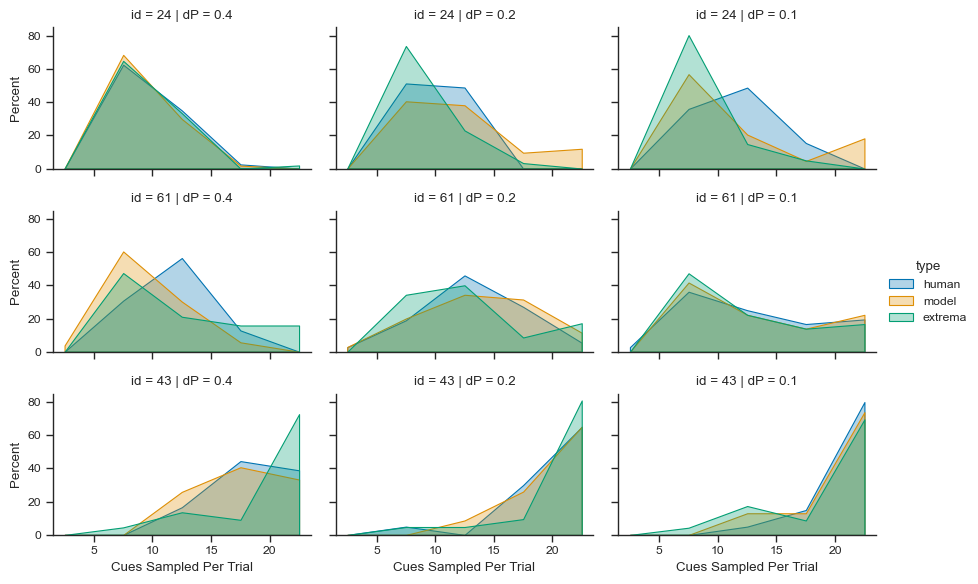

In [27]:
plot_id_RTs([24, 61, 43], "fiedler_trial_may8b", "fiedler_trial", "extrema_trial_fit", max_cues=12, cue_step=5)

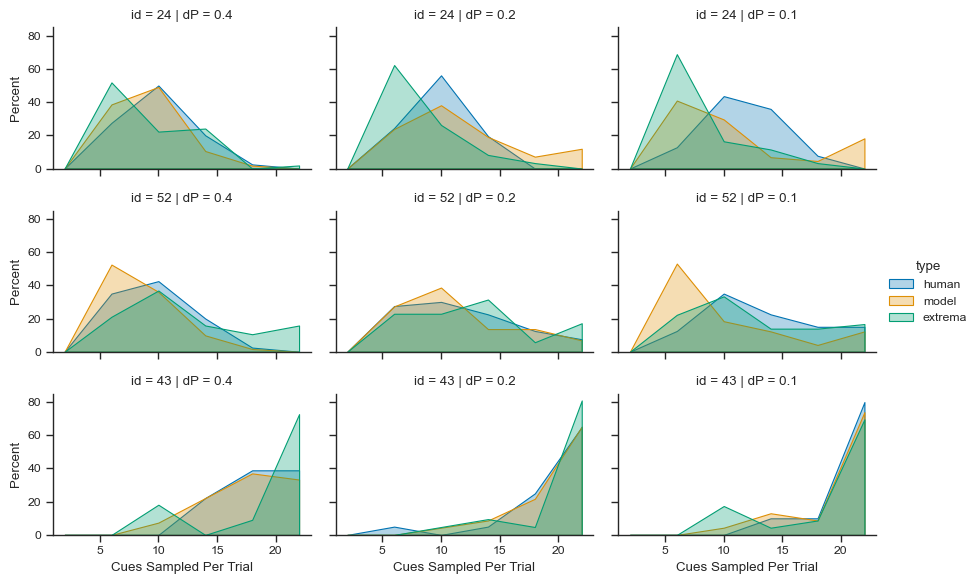

In [29]:
plot_id_RTs([24, 52, 43], "fiedler_trial_may8b", "fiedler_trial", "extrema_trial_fit", max_cues=12, cue_step=4)

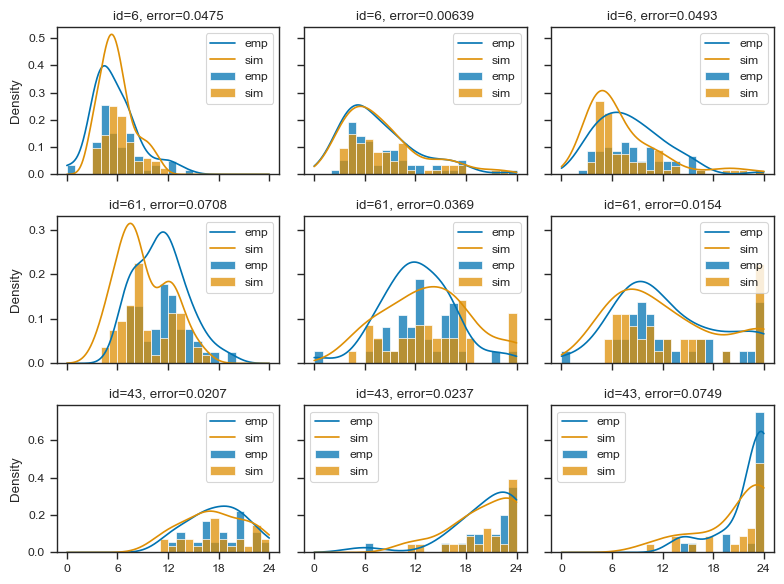

In [172]:
max_cues=12
bw=1
cut=0
emp = pd.read_pickle(f"data/fiedler_trial.pkl").query("max_cues==@max_cues")
sim = pd.read_pickle(f"data/fiedler_trial_may8b.pkl").query("max_cues==@max_cues")

# ids=emp['id'].unique()
# print(ids)
# raise
ids = [6, 61, 43]

# fig = sns.FacetGrid(emp.query("id in @ids"), row="id", col="dP", sharey='row',
#                     row_order=ids, col_order=[0.4, 0.2, 0.1], palette=palette, height=2, aspect=1.5)
# fig.map_dataframe(sns.histplot, x="cues", stat='density', kde=True, kde_kws={'bw_adjust': bw, 'cut': cut, 'clip': None},
#                   bins=np.arange(0, 2*max_cues+1, 1), common_norm=False)
# fig.set_xlabels("Cues Sampled Per Trial")
# fig.set(xticks=[0,6,12,18,24])
# fig.add_legend()
# fig.savefig(f"plots/test_kde1.svg")
# fig.savefig(f"plots/test_kde1.png", dpi=600)

fig, axes = plt.subplots(nrows=len(ids), ncols=3, figsize=((8, 2*len(ids))), sharey='row', sharex=True)
for i, pid in enumerate(ids):
    strpid = str(pid)
    for p, dP in enumerate([0.4, 0.2, 0.1]):
        cues_emp = emp.query("id==@pid & dP==@dP")['cues'].to_numpy()
        cues_sim = sim.query("id==@strpid & dP==@dP")['cues'].to_numpy()
        unique_emp = emp.query("id==@pid & dP==@dP")['cues'].unique()
        unique_sim = sim.query("id==@strpid & dP==@dP")['cues'].unique()

        eval_points = np.linspace(0, 2*max_cues, 1000)
        kde_emp = gaussian_kde(cues_emp, bw_method='scott')
        kde_sim = gaussian_kde(cues_sim, bw_method='scott')
        estimate_emp = kde_emp.evaluate(eval_points)
        estimate_sim = kde_sim.evaluate(eval_points)
        estimate_emp = estimate_emp / np.sum(estimate_emp)
        estimate_sim = estimate_sim / np.sum(estimate_sim)
        sns.histplot(cues_emp, stat='density', bins=np.arange(0, 2*max_cues+1, 1), common_norm=False, ax=axes[i][p], label='emp', color=palette[0])
        if len(unique_emp)>1:
            sns.lineplot(x=eval_points, y=100*estimate_emp, ax=axes[i][p], label='emp', color=palette[0])
        sns.histplot(cues_sim, stat='density', bins=np.arange(0, 2*max_cues+1, 1), common_norm=False, ax=axes[i][p], label='sim', color=palette[1])
        if len(unique_sim)>1:
            sns.lineplot(x=eval_points, y=100*estimate_sim, ax=axes[i][p], label='sim', color=palette[1])
        error = 100*np.sqrt(np.mean(np.square(estimate_emp - estimate_sim)))
        axes[i][p].set(title=f"id={pid}, error={error:.3}")
        
axes[0][0].set(xticks=[0,6,12,18,24])
plt.tight_layout()
plt.show()

# Plot distribution of mean RTs and Accuracies across participants

In [116]:
def compute_means(simfile, empfile, extrfile):
    emp = pd.read_pickle(f"data/{empfile}.pkl")
    sim = pd.read_pickle(f"data/{simfile}.pkl")
    extr = pd.read_pickle(f"data/{extrfile}.pkl")
    combined = pd.concat([emp, sim, extr], ignore_index=True)
    combined = combined.astype({"id": int})
    columns = ['type', 'id', 'difficulty', 'max_cues', 'mean_RT', 'mean_acc']
    dfs = []
    for id_type in combined['type'].unique():
        for pid in combined['id'].unique():
            for i, dP in enumerate([0.4, 0.2, 0.1]):
                for max_cues in [12, 18]:
                    data = combined.query("type==@id_type & id==@pid & dP==@dP & max_cues==@max_cues")
                    mean_RT = data['cues'].mean()
                    mean_acc = data['accuracy'].mean()
                    if id_type=='human':
                        mean_acc *= 100
                    difficulty = ['easy', 'moderate', 'hard'][i]
                    df = pd.DataFrame([[
                        id_type, pid, difficulty, max_cues, mean_RT, mean_acc
                        ]], columns=columns)
                    dfs.append(df)
    mean_data = pd.concat(dfs, ignore_index=True)
    mean_data.to_pickle("data/mean_data.pkl")

In [117]:
compute_means("fiedler_trial_may8b", "fiedler_trial", "extrema_trial_fit")

In [118]:
def plot_mean_distributions(meanfile, max_cues, cue_step=5):
    data = pd.read_pickle(f"data/{meanfile}.pkl").query("max_cues==@max_cues")

    bins = np.arange(0, 2*max_cues+cue_step, cue_step)
    fig = sns.FacetGrid(data, row=None, hue='type', col="difficulty", col_order=["easy", "moderate", "hard"], palette=palette, height=2, aspect=1.5)
    fig.map_dataframe(sns.histplot, x="mean_RT", stat='percent', element="poly", bins=bins, common_norm=False)
    fig.set_xlabels("Individual's Mean RT")
    fig.add_legend()
    fig.savefig(f"plots/fiedler_mean_RTs.svg")
    fig.savefig(f"plots/fiedler_mean_RTs.png", dpi=600)

    bins = np.arange(40, 110, 10)
    fig = sns.FacetGrid(data, row=None, hue='type', col="difficulty", col_order=["easy", "moderate", "hard"], palette=palette, height=2, aspect=1.5)
    fig.map_dataframe(sns.histplot, x="mean_acc", stat='percent', element="poly", bins=bins, common_norm=False)
    fig.set_xlabels("Individual's Mean Accuracy")
    fig.add_legend()
    fig.savefig(f"plots/fiedler_mean_accs.svg")
    fig.savefig(f"plots/fiedler_mean_accs.png", dpi=600)

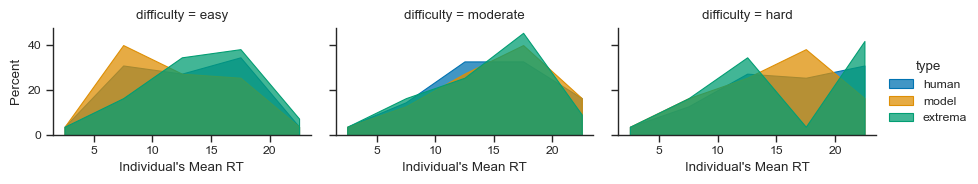

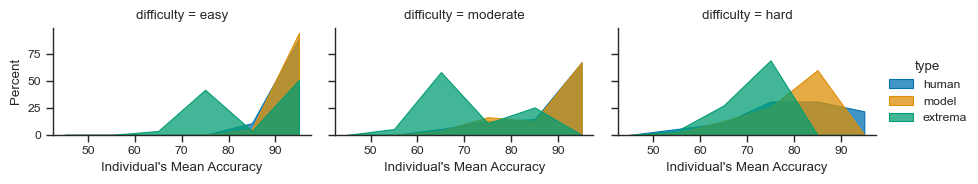

In [119]:
plot_mean_distributions("mean_data", max_cues=12)

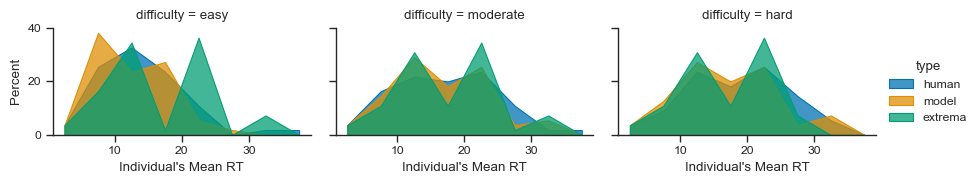

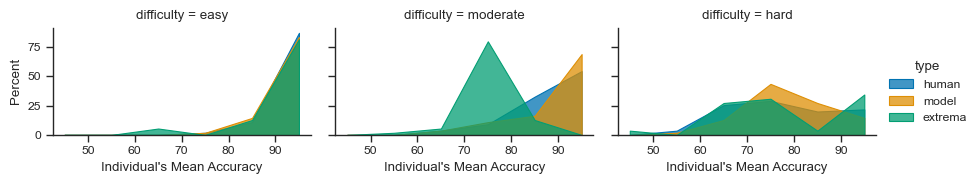

In [120]:
plot_mean_distributions("mean_data", max_cues=18)

# Plot Error Distributions
Compute the chi-squared distance between empirical and model/extrema distribution for each individual and each condition.

Compute the absolute difference in mean accuracy (across trials) for each individual and each condition.

Then plot the distribution of these two error metrics across individuals

In [121]:
def compute_RT_errors(simfile, empfile, extrfile, cue_step=5, aggregate=True):
    emp = pd.read_pickle(f"data/{empfile}.pkl")
    sim = pd.read_pickle(f"data/{simfile}.pkl")
    extr = pd.read_pickle(f"data/{extrfile}.pkl")
    combined = pd.concat([emp, sim, extr], ignore_index=True)
    combined = combined.astype({"id": int})
    columns = ['type', 'id', 'difficulty', 'max_cues', 'chi2']
    dfs = []
    for model_type in ['model', 'extrema']:
        for pid in combined['id'].unique():
            for i, dP in enumerate([0.4, 0.2, 0.1]):
                for max_cues in [12, 18]:
                    bins = np.arange(0, 2*max_cues+cue_step, cue_step)
                    difficulty = ['easy', 'moderate', 'hard'][i]
                    empirical = combined.query("type=='human' & id==@pid & dP==@dP & max_cues==@max_cues")
                    simulated = combined.query("type==@model_type & id==@pid & dP==@dP & max_cues==@max_cues")
                    hist_empirical = np.histogram(empirical['cues'].to_numpy(), bins=bins)[0]
                    hist_simulated = np.histogram(simulated['cues'].to_numpy(), bins=bins)[0]
                    accs_empirical = empirical['accuracy'].to_numpy()
                    accs_simulated = simulated['accuracy'].to_numpy()
                    normed_empirical = hist_empirical / len(empirical)
                    normed_simulated = hist_simulated / len(simulated)
                    chi2 = chi_squared_distance(normed_empirical, normed_simulated)
                    df = pd.DataFrame([[
                        model_type, pid, difficulty, max_cues, chi2,
                        ]], columns=columns)
                    dfs.append(df)
    error_data = pd.concat(dfs, ignore_index=True)
    error_data.to_pickle("data/error_data.pkl")

In [122]:
compute_RT_errors("fiedler_trial_may8b", "fiedler_trial", "extrema_trial_fit", cue_step=5)

In [123]:
# pd.read_pickle("data/error_data.pkl")

In [124]:
def plot_error_distributions(errorfile):
    error = pd.read_pickle(f"data/{errorfile}.pkl")
    chi2_bins = np.arange(0, 1.1, 0.1)
    fig = sns.FacetGrid(error, row='max_cues', hue='type', col="difficulty", col_order=["easy", "moderate", "hard"], palette=palette, height=2, aspect=1.5)
    fig.map_dataframe(sns.histplot, x="chi2", stat='percent', element="poly", bins=chi2_bins, common_norm=False)
    fig.set_xlabels("Chi2 (human RT, model RT)")
    fig.add_legend()
    fig.savefig(f"plots/fiedler_RT_errors.svg")
    fig.savefig(f"plots/fiedler_RT_errors.png", dpi=600)

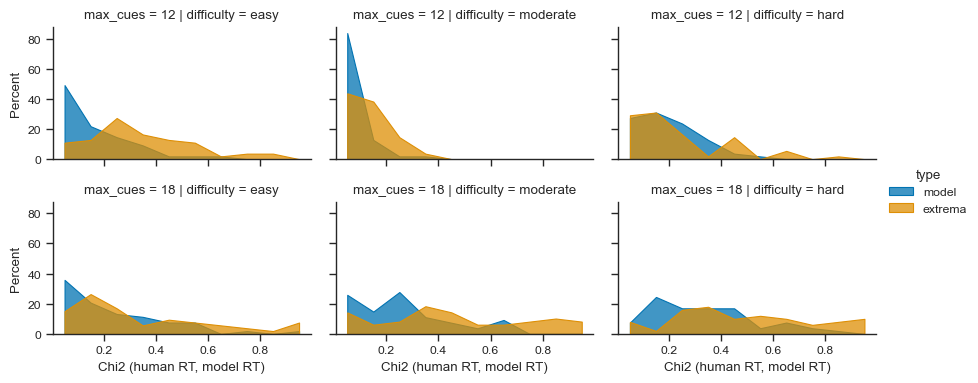

In [125]:
plot_error_distributions("error_data")

# Plot SAT and Efficiency Curves

In [126]:
def compute_sat(simfile, empfile, extrfile):
    emp = pd.read_pickle(f"data/{empfile}.pkl")
    sim = pd.read_pickle(f"data/{simfile}.pkl")
    extr = pd.read_pickle(f"data/{extrfile}.pkl")
    combined = pd.concat([emp, sim, extr], ignore_index=True)   
    combined = combined.astype({"id": int})
    difficulties = ["easy", "moderate", "hard"]
    dfs = []
    dfs2 = []
    columns = ['type', 'id', 'difficulty', 'max_cues', 'mean cues', 'mean acc', 'nTrials', 'efficiency']
    columns2 = ['type', 'id', 'difficulty', 'max_cues', 'mean cues', 'dependent_var', 'value']
    for id_type in combined['type'].unique():
        for pid in combined['id'].unique():
            for i, dP in enumerate(combined['dP'].unique()):
                for max_cues in combined['max_cues'].unique():
                    data = combined.query("type==@id_type & id==@pid & dP==@dP & max_cues==@max_cues")
                    mean_cues = data['cues'].mean()
                    mean_acc = data['accuracy'].mean()
                    if id_type=='human':
                        mean_acc *= 100
                    nTrials = len(data['trial'].unique())
                    efficiency = mean_acc * nTrials / 100
                    difficulty = difficulties[i]
                    dfs.append(pd.DataFrame([[id_type, pid, difficulty, max_cues, mean_cues, mean_acc, nTrials, efficiency]], columns=columns))
                    dfs2.append(pd.DataFrame([[id_type, pid, difficulty, max_cues, mean_cues, "mean_acc", mean_acc]], columns=columns2))
                    dfs2.append(pd.DataFrame([[id_type, pid, difficulty, max_cues, mean_cues, "nTrials", nTrials]], columns=columns2))
                    dfs2.append(pd.DataFrame([[id_type, pid, difficulty, max_cues, mean_cues, "efficiency", efficiency]], columns=columns2))
    collapsed = pd.concat(dfs, ignore_index=True)
    collapsed2 = pd.concat(dfs2, ignore_index=True)
    collapsed.to_pickle(f"data/sat.pkl")
    collapsed2.to_pickle(f"data/sat2.pkl")

In [127]:
compute_sat("fiedler_trial_may8b", "fiedler_trial", "extrema_trial_fit")

In [128]:
def plot_SAT(satfile, cue_step=5):
    data = pd.read_pickle(f"data/{satfile}.pkl")
    difficulties = ["easy", "moderate", "hard"]
    fig = sns.FacetGrid(data, row='max_cues', col="difficulty", hue='type', col_order=difficulties,
                        sharex='row', palette=palette[:3], height=2, aspect=1.5)
    fig.map_dataframe(sns.regplot, x="mean cues", y="mean acc", scatter_kws={'s': 2}, order=2)
    fig.set_xlabels("Mean Cues")
    fig.set_ylabels("Mean Accuracy")
    fig.set(yticks=[50, 60, 70, 80, 90, 100], ylim=[50, 110])  # xticks=np.arange(0, max_cues*2+cue_step, cue_step), 
    fig.add_legend()
    fig.savefig(f"plots/fiedler_SAT.svg")
    fig.savefig(f"plots/fiedler_SAT.png", dpi=600)

    # for difficulty in difficulties:
    #     x = collapsed.query("difficulty==@difficulty & type=='human'")['mean cues'].to_numpy()
    #     y = collapsed.query("difficulty==@difficulty & type=='human'")['mean acc'].to_numpy()
    #     x2 = collapsed.query("difficulty==@difficulty & type=='model'")['mean cues'].to_numpy()
    #     y2 = collapsed.query("difficulty==@difficulty & type=='model'")['mean acc'].to_numpy()
    #     res_human = linregress(x, y)
    #     res_agent = linregress(x2, y2)
    #     print(difficulty)
    #     print("human", res_human)
    #     print("agent", res_agent)
    #     print(ancova(data=collapsed.query("difficulty==@difficulty"), dv='mean acc', covar='mean cues', between='type'))

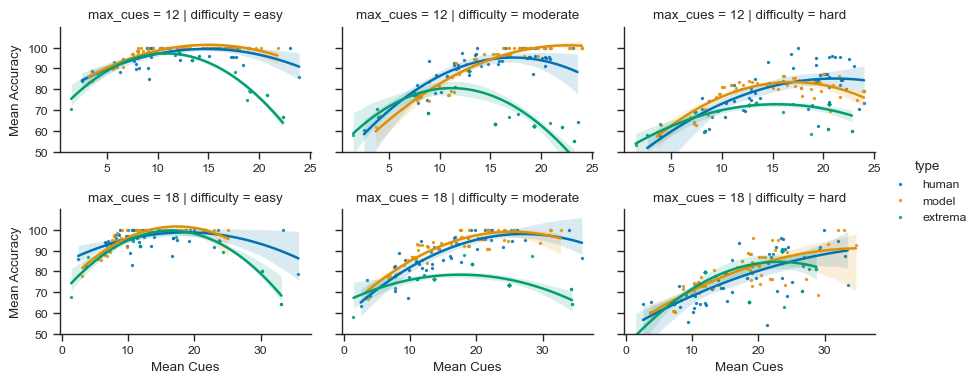

In [129]:
plot_SAT("sat")

In [130]:
def plot_efficiency(satfile, max_cues=12):
    difficulties=["easy", "moderate", "hard"]
    data = pd.read_pickle(f"data/{satfile}.pkl").query("max_cues==@max_cues")
    fig = sns.FacetGrid(data, col="difficulty", row='dependent_var', hue='type',
                        sharex=True, sharey='row', col_order=difficulties, palette=palette[:3], height=2, aspect=1.5)
    # fig.map_dataframe(sns.scatterplot, x="mean cues", y="value", s=6)
    fig.map_dataframe(sns.regplot, x="mean cues", y="value", scatter_kws={'s': 2}, order=2)
    fig.set_xlabels("Mean Cues")
    fig.add_legend()
    # fig.set(xticks=np.arange(0, max_cues*2+4, 4))
    axes = fig.axes.flatten()
    for ax in axes:
        ax.set(title=None, ylabel=None)
    axes[0].set(title="difficulty = easy")
    axes[1].set(title="difficulty = moderate")
    axes[2].set(title="difficulty = hard")
    axes[0].set(ylabel="Mean Accuracy", yticks=[50, 60, 70, 80, 90, 100], ylim=[50, 110])
    axes[3].set(ylabel="Total Trials", yticks=[0, 50, 100, 150, 200], ylim=[0, 150])
    axes[6].set(ylabel="Total Reward", yticks=[0, 50, 100, 150], ylim=[0, 150])
    fig.savefig(f"plots/fiedler_efficiency.svg")
    fig.savefig(f"plots/fiedler_efficiency.png", dpi=600)

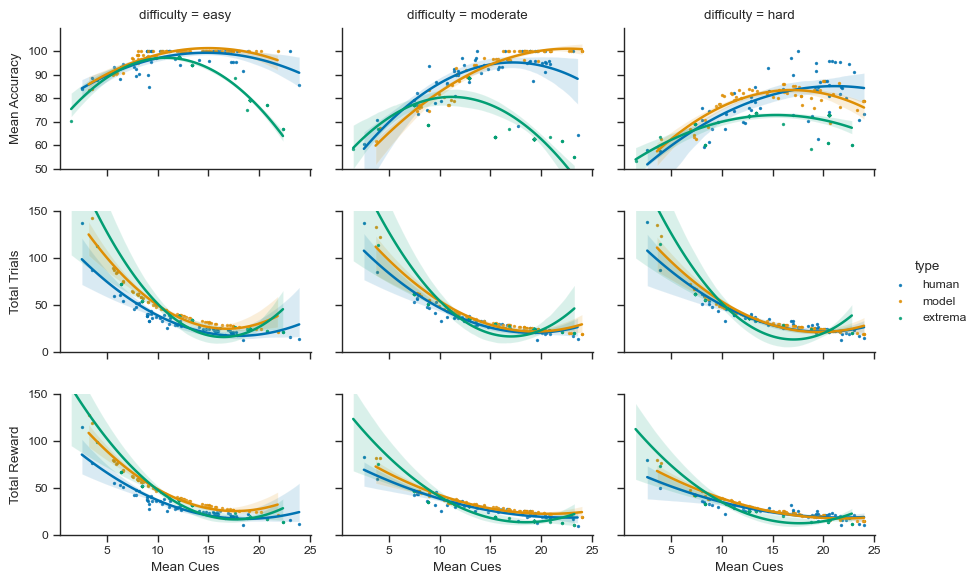

In [131]:
plot_efficiency("sat2", max_cues=12)